In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [2]:
(beans_train,beans_test), info = tfds.load("beans", with_info=True, split=["train", 'test'], as_supervised=True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [4]:
class_names= info.features['label'].names
print(class_names)

['angular_leaf_spot', 'bean_rust', 'healthy']


In [5]:
num_train_examples= info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
print(num_train_examples)
print(num_test_examples)

1034
128


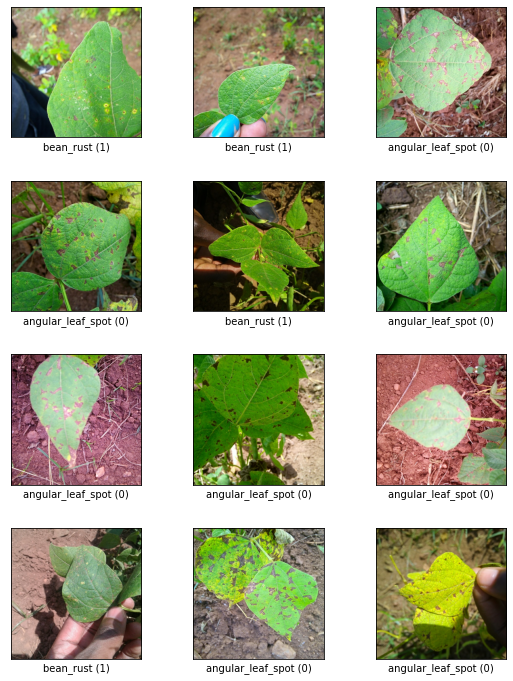

In [6]:
fig= tfds.show_examples(beans_train,info,rows=4, cols=3)

In [7]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    return image, label


In [8]:
train_dataset = beans_train.map(normalize_img)
test_dataset = beans_test.map(normalize_img)


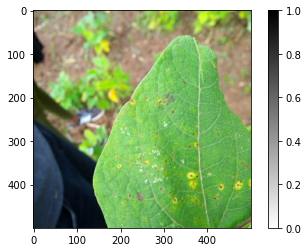

In [9]:
for image, label in train_dataset.take(3):
    break

image= image.numpy().reshape((500,500,3))


plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
# Build the Model

model= tf.keras.Sequential([tf.keras.layers.Conv2D(32,(3,3), input_shape=(500,500,3), activation ='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            
                            tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),

                            tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),

                            tf.keras.layers.Dropout(0.4),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(128,activation='relu'),
                            tf.keras.layers.Dense(3, activation='softmax')

                            ])

In [11]:
#Compile Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
batch_size=24
train_dataset =train_dataset.cache().repeat().shuffle(num_train_examples).batch(batch_size)
test_dataset = test_dataset.cache().batch(batch_size)

In [13]:
import math
#Fit the model
model.fit(train_dataset, epochs=5, steps_per_epoch= math.ceil(num_train_examples/batch_size))

Epoch 1/5
44/44 [==============================] - 678s 15s/step - loss: 1.7870 - accuracy: 0.5246
Epoch 2/5
44/44 [==============================] - 698s 16s/step - loss: 0.6745 - accuracy: 0.6922
Epoch 3/5
44/44 [==============================] - 713s 16s/step - loss: 0.5403 - accuracy: 0.7699
Epoch 4/5
44/44 [==============================] - 696s 16s/step - loss: 0.4132 - accuracy: 0.8456
Epoch 5/5
44/44 [==============================] - 689s 16s/step - loss: 0.3321 - accuracy: 0.8778


In [14]:
#Evaluate Accuracy
test_loss, test_accuracy  = model.evaluate(test_dataset, steps = math.ceil(num_test_examples/batch_size))

print('Accuracy on test dataset:', test_accuracy)

6/6 [==============================] - 20s 3s/step - loss: 0.5368 - accuracy: 0.7656
Accuracy on test dataset: 0.765625


In [15]:
#Make Predictions and explore on TEST dataset
for test_images, test_labels  in test_dataset.take(1):

    test_images = test_images.numpy()
    test_labels= test_labels.numpy()
    predictions = model.predict(test_images) 

In [16]:
predictions.shape  # return batch size and class number

(24, 3)

In [17]:
#Checking random prediction
print(predictions[4])
np.argmax(predictions[4])

[1.4583198e-03 1.2066800e-04 9.9842107e-01]


2

In [18]:
test_labels[4]

2

In [19]:
# Graph 15 predictions with actual label

def plot_image(i, predictions_array, true_label, images):
    predictions_array, true_label, img= predictions_array[i], true_label[i], images[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img ,  cmap=plt.cm.binary)
  

    predicted_label =np.argmax(predictions_array)
    if predicted_label ==true_label:
        color = 'blue'
    else:
        color = 'red'


    plt.xlabel("{}  {:2.0f}% ({})". format (class_names[predicted_label], 100*np.max(predictions_array),class_names[true_label]),
             color=color)


In [20]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label =predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#00FF99")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

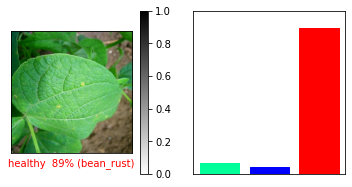

In [21]:
i=3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.colorbar()
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

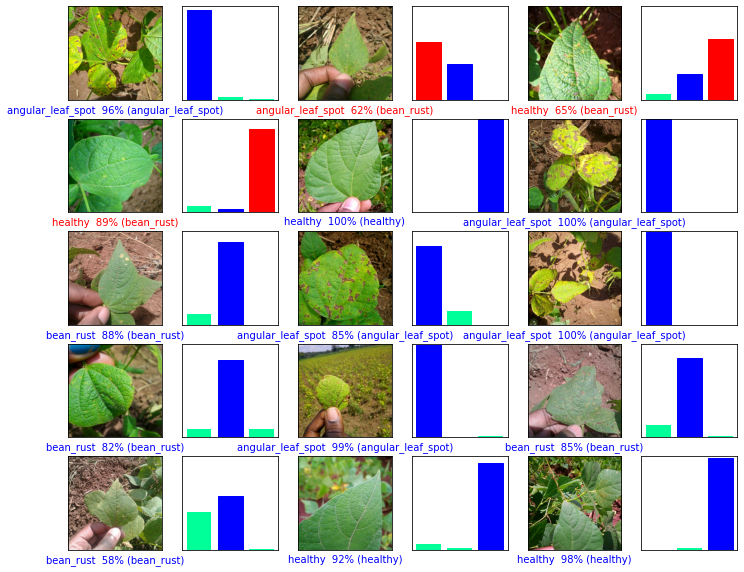

In [22]:
#Plotting several images
num_rows = 5
num_cols = 3
num_images= num_rows*num_cols

plt.figure(figsize = (2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)